In [9]:
using DifferentialEquations
using PyCall
import Random
# using PyPlot
using Statistics
using BenchmarkTools
using Base.Threads
using Plots
import PyPlot
pl = PyPlot;

In [10]:
function KM_model(du, u, p, t)
    
    omega = p[3]
    adj = p[4]
    
    for i = 1:p[2]
        du[i] = omega[i] + p[1] * sum(adj[:, i] .* sin.(u .- u[i]))
    end
    du
end

function sKM_model(du, u, p, t)
    for i = 1:p[2]
        du[i] = p[5]
    end
    du
end

# p = [K[1]/N, N, omega_0, adj, noise_amp]

function order(theta)
    
    n = length(theta)
    
    real_R = 0.0
    imag_R = 0.0
    
    for i = 1:n
        real_R += cos(theta[i])
        imag_R += sin(theta[i])
    end
    
    real_R /= n
    imag_R /= n
    r = sqrt(real_R * real_R + imag_R * imag_R)
    
    return r
end

order (generic function with 1 method)

In [11]:
Random.seed!(1234)

K = 0.5                   
N = 5             
dt = 0.01                    
T = 100.0                   
T_trans = 0.0                
mu = 1.0                     
sigma = 0.1 
noise_amp = 0.01
n_simulation = 30

p = 0.5
# R = zeros(length(K))

nx = pyimport("networkx")
np = pyimport("numpy")

G = nx.gnp_random_graph(N, p, seed=1)
adj = nx.to_numpy_array(G, dtype=np.int)

ind_transition = Int64(T_trans/dt)
theta_0 = rand(N) .* 2.0 .* pi .- pi
omega_0 = randn(N) .* sigma .+ mu 
tspan = (0.0, T)
p = [K/N, N, omega_0, adj, noise_amp]
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, tspan, p);

In [12]:
function prob_func(prob, i, repeat)
  remake(prob, u0 = rand(N) .* 2.0 .* pi .- pi)
end

prob_func (generic function with 1 method)

In [13]:
ensemble_prob = EnsembleProblem(prob_sde, prob_func=prob_func)
sim = solve(ensemble_prob,
            SOSRA(),
            EnsembleThreads(),
            trajectories=n_simulation,
            saveat=0.1);

In [6]:
function plot_r(sol, ax)
    nstep = length(sol.t)
    r = zeros(nstep)
    for j =1:nstep
        r[j] = order(sol.u[j])
    end
#     println(mean(r), " ", length(sol.t))
    ax.plot(sol.t, r);
end;

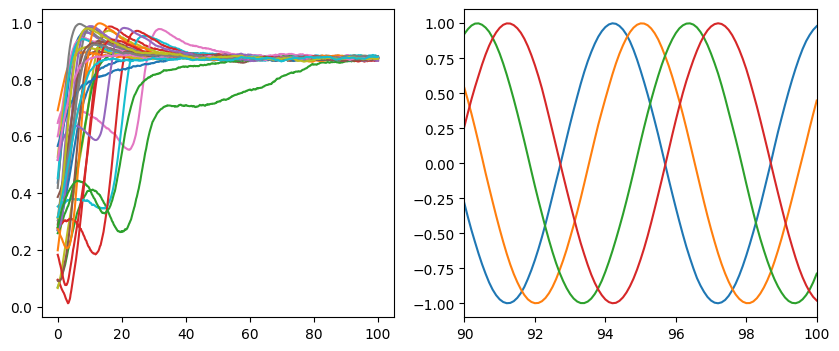

In [7]:
fig, ax = pl.subplots(ncols=2, nrows=1, figsize=(10, 4))
for i=1:n_simulation
    plot_r(sim.u[i], ax[1])

    phases = hcat(sim[i].u...);
#     println(size(phases))
    if i<3
        for j =1:2
            ax[2].plot(sim[i].t, sin.(phases[j, :]))
        end
    end
end
ax[2].set_xlim(90, 100)
pl.show()

In [17]:
# plot(sim, linealpha=1)
# println(typeof(sim.u))
println(length(sim.u))
println(length(sim.u[1]))
println(length(sim.u[1][1]))
println(length(sim[1].t))
# println(typeof(sim.u[1]))


30
1001
5
1001
